## Poisson model

In [1]:
#import os,sys

#pymc3_path = os.path.join(os.environ["HOME"], "repos", "lib", "pymc3")
#sys.path.insert(0, pymc3_path)

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from theano import tensor as ts
import pymc3 as pm

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8,6)

In [3]:
#from blaze import Data
#from odo import odo

#t = Data("sqlite:///data.sqlite3::train")
#usecols = ["week_num","agency_id","product_id","adjusted_demand"]
#t = t[usecols]
#t = t.sample(n=200000)
#odo(t, "downloads/test-samp-200k.csv")

In [4]:
train_samp = pd.read_csv("downloads/train-samp-200k.csv")
train_samp.head()

,week_num,agency_id,product_id,adjusted_demand
0,4,1550,1240,2
1,5,1120,30549,5
2,3,1354,34211,125
3,3,3217,1150,1
4,9,1334,35309,3


In [5]:
n_weeks = len(np.unique(train_samp.week_num))
n_agencies = len(np.unique(train_samp.agency_id))
n_products = len(np.unique(train_samp.product_id))

In [6]:
print("Number of weeks: {}\n Number of products: {}\n Number of agencies {}".format(n_weeks,n_products,n_agencies))

Number of weeks: 7
 Number of products: 1060
 Number of agencies 545


In [7]:
class Encoder:
    
    def __init__(self):
        self._week_le = LabelEncoder()
        self._agency_le = LabelEncoder()
        self._product_le = LabelEncoder()
    
    def transform(self, df):
        week_code = self._week_le.fit_transform(df.week_num)
        agency_code = self._agency_le.fit_transform(df.agency_id)
        product_code = self._product_le.fit_transform(df.product_id)
        return week_code, agency_code, product_code

le = Encoder()

In [8]:
week_code, agency_code, product_code = le.transform(train_samp)

In [9]:
train_samp.adjusted_demand.describe()

count    200000.000000
mean          7.326820
std          20.721818
min           0.000000
25%           2.000000
50%           3.000000
75%           6.000000
max        1968.000000
Name: adjusted_demand, dtype: float64

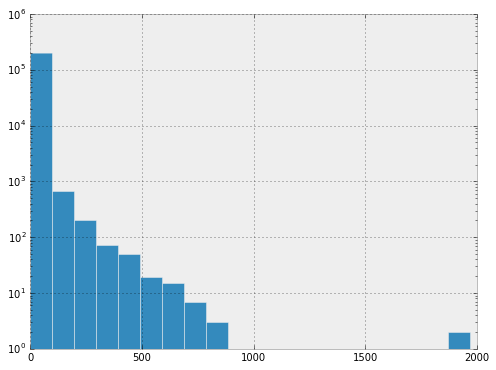

In [10]:
train_samp.adjusted_demand.hist(bins=20, log=True)

### Build The model

In [11]:
pois_model = pm.Model()

with pois_model:
    
    week_rate = pm.HalfNormal("week_rate", sd=10, shape=n_weeks)
    agency_rate = pm.HalfNormal("agency_rate", sd=10, shape=n_agencies)
    product_rate = pm.HalfNormal("product_rate", sd=10, shape=n_products)
    
    demand_rate = pm.Deterministic("demand_rate", week_rate[week_code] + product_rate[product_code] + agency_rate[agency_code])
    
    adjusted_demand = pm.Poisson("adjusted_demand", mu=demand_rate, observed=train_samp.adjusted_demand)

Applied log-transform to week_rate and added transformed week_rate_log to model.
Applied log-transform to agency_rate and added transformed agency_rate_log to model.
Applied log-transform to product_rate and added transformed product_rate_log to model.


In [12]:
pois_model.vars

[week_rate_log, agency_rate_log, product_rate_log]

In [13]:
with pois_model:
    advi_fit = pm.advi(n=10000)

Iteration 0 [0%]: ELBO = -5428044.3
Iteration 1000 [10%]: Average ELBO = -4909856.94
Iteration 2000 [20%]: Average ELBO = -3364729.78
Iteration 3000 [30%]: Average ELBO = -2419918.84
Iteration 4000 [40%]: Average ELBO = -1844274.79
Iteration 5000 [50%]: Average ELBO = -1473090.22
Iteration 6000 [60%]: Average ELBO = -1250233.33
Iteration 7000 [70%]: Average ELBO = -1124492.7
Iteration 8000 [80%]: Average ELBO = -1054640.01
Iteration 9000 [90%]: Average ELBO = -1011945.97
Finished [100%]: Average ELBO = -988047.76


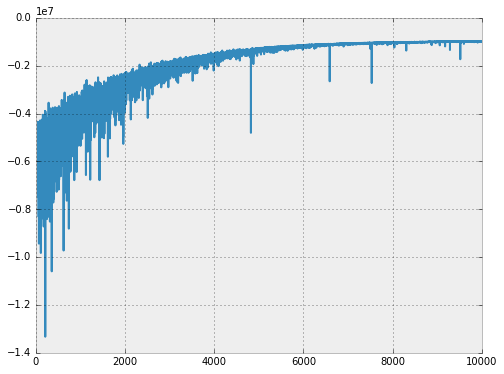

In [14]:
plt.plot(advi_fit.elbo_vals)

In [15]:
np.exp(advi_fit.means["week_rate_log"])

array([ 1.05155708,  1.10299237,  1.13512228,  1.0653059 ,  1.13704004,
        1.01188659,  0.96718892])

In [16]:
np.exp(advi_fit.stds["week_rate_log"])

array([ 1.27349079,  1.26309648,  1.25221199,  1.2596099 ,  1.2562945 ,
        1.26209205,  1.27462808])

In [17]:
with pois_model:
    trace_pois = pm.sample_vp(advi_fit, draws=500)

In [18]:
trace_pois["week_rate"].mean(0)

array([ 1.08993951,  1.12012539,  1.17048359,  1.09442067,  1.16546482,
        1.05322016,  0.99445626])

In [19]:
trace_pois["week_rate"].var(0)

array([ 0.06649126,  0.06924958,  0.06450854,  0.06774406,  0.07159039,
        0.06205823,  0.06296767])

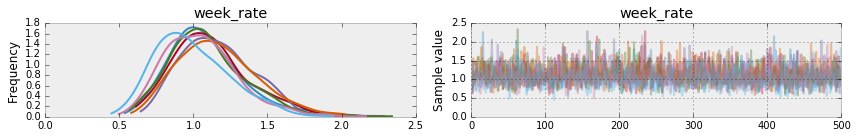

In [20]:
_ = pm.traceplot(trace_pois, varnames=["week_rate"])

In [21]:
with pois_model:
    ppc = pm.sample_ppc(trace_pois, samples=100)

In [23]:
train_samp.adjusted_demand.describe()

count    200000.000000
mean          7.326820
std          20.721818
min           0.000000
25%           2.000000
50%           3.000000
75%           6.000000
max        1968.000000
Name: adjusted_demand, dtype: float64

In [22]:
pd.Series(np.median(ppc["adjusted_demand"],0)).describe()

count    200000.000000
mean          6.890772
std           9.318356
min           1.000000
25%           3.000000
50%           4.000000
75%           7.000000
max         221.000000
dtype: float64

In [29]:
pd.Series(np.mean(ppc["adjusted_demand"],0)).describe()

count    200000.000000
mean          7.170032
std          10.016186
min           1.690000
25%           3.300000
50%           4.620000
75%           7.120000
max         360.340000
dtype: float64

### Error metrics

#### Root Mean Squared Logarithmic Error

$\epsilon$ = $\sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(p_i + 1) - \log(a_i + 1))^2}$

Ref: https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError

In [30]:
from utils import rmsle

In [32]:
errors = np.array([rmsle(train_samp.adjusted_demand.values, s) for s in ppc["adjusted_demand"]])

In [33]:
np.mean(errors)

0.80755212621009842

In [35]:
rmsle(train_samp.adjusted_demand.values, np.mean(ppc["adjusted_demand"], axis=0))

0.70609661369178511

In [36]:
np.median(errors)

0.80745818610130704

In [37]:
rmsle(train_samp.adjusted_demand.values, np.median(ppc["adjusted_demand"], axis=0))

0.69623616993975435

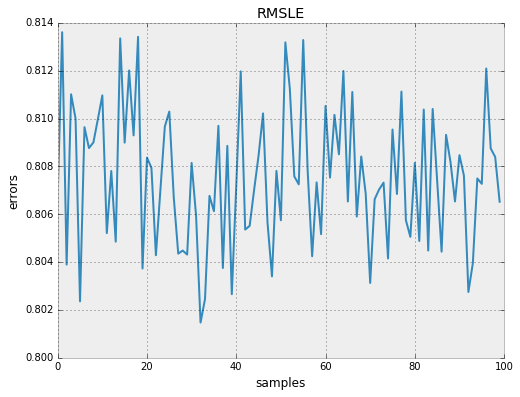

In [38]:
plt.plot(errors)
plt.title("RMSLE")
plt.xlabel("samples")
plt.ylabel("errors")

In [39]:
print("Best error: {:.3f}".format(errors[np.argmin(errors)]))

Best error: 0.801


In [40]:
def plot_ppc(ppc_var, name="median"):
    funs = {"mean":np.mean, "median":np.median}
    f = funs[name]
    n_samp = ppc_var.shape[0]
    fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

    axs[0].hist(train_samp.adjusted_demand, bins=20, log=True)
    axs[0].set_title("Observed data")

    axs[1].hist(f(ppc_var, axis=0), bins=20)
    axs[1].set_title("Posterior %s (%d samples)" % (name, n_samp))

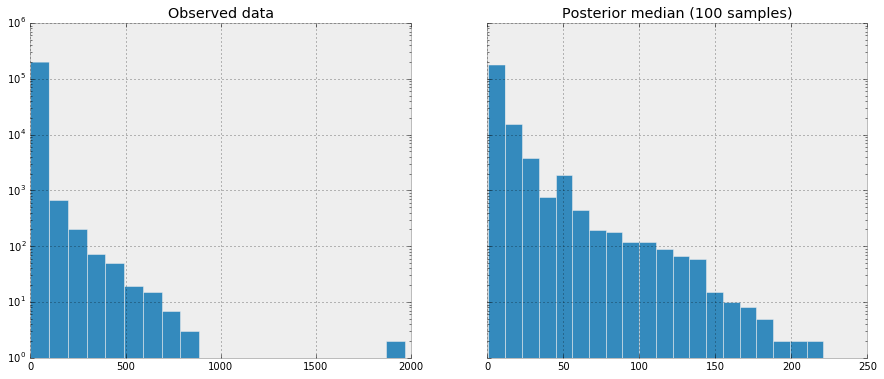

In [42]:
plot_ppc(ppc["adjusted_demand"])

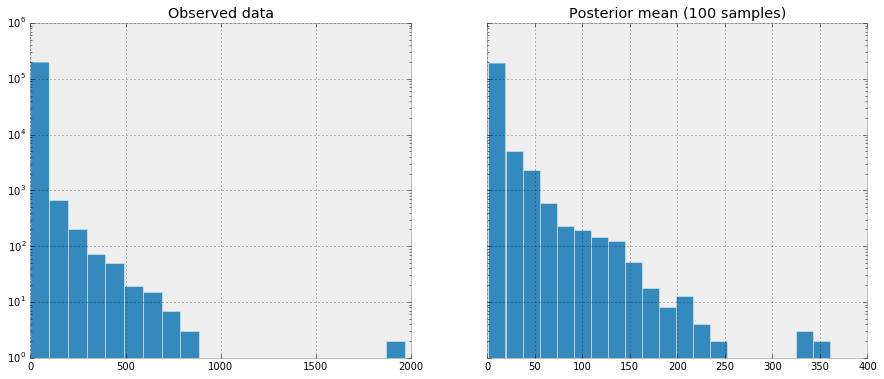

In [43]:
plot_ppc(ppc["adjusted_demand"], name="mean")